## Libraries and Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('ggplot')

import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

from collections import defaultdict
from IPython import display
import time
import os

import re


LABELS_PATH = '//data/cms2010/labels_v2.pickled'

with open(LABELS_PATH, 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    sub_labels = u.load()
labels = sub_labels['json_0.txt']    
data = pd.read_csv('//data/cms2010//merged_23')

In [2]:
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('grid', linestyle="-", color='gray')
plt.rc('axes', edgecolor='gray')

In [3]:
### technical columns
not_features = [
    '_luminosityBlock',
    '_run'
]

### columns that correspond to actual features
features = sorted(set(data.columns) - set(not_features))

for f in features:
    xs = data[f].values

    if np.std(xs) > 0.0:
        data[f] = (xs - np.mean(xs)) / np.std(xs)
        
lumi = np.maximum(
    np.maximum(data['_instantLumi_minibias'].get_values(), data['_instantLumi_muons'].get_values()),
    data['_instantLumi_photons'].get_values()
)

nonempty = np.where(lumi > 0.0)[0]
data = data.iloc[nonempty]
lumi = lumi[nonempty]
labels = labels[nonempty]

for k in sub_labels:
    sub_labels[k] = sub_labels[k][nonempty]


In [4]:
lumi_bad = np.sum(lumi[labels == 0.0])
lumi_good = np.sum(lumi[labels == 1.0])
### By normalizing weights we implicitly define equal probabilities for each class
weights = lumi / np.where(labels == 1.0, lumi_good, lumi_bad)
weights *= lumi.shape[0]
w_bad = np.sum(weights[labels == 0.0])
w_good = np.sum(weights[labels == 1.0])

In [5]:
### utility functions
def insert(keys, d, f):
    key = keys[0]

    if len(keys) == 1:
        d[key] = f
    else:
        if key not in d:
            d[key] = dict()
        return insert(keys[1:], d[key], f)

def levels(features, n_levels = 5):
    dicts = [features]

    levels = list()

    for level in range(n_levels):
        levels.append(
            set([ k for d in dicts for k in d ])
        )
    
        dicts = [ d[k] for d in dicts for k in d ]
    return levels
    
def get_feature_groups(feature_list, re_exp):
    """
    Retuns:
    1. hierachical dictionary feature groups -> feature full name
    2. feature levels
    3. unprocessed features
        
    """
    features = dict()
    rest = list()
    n_levels = set()

    for f in feature_list:
        matches = re.findall(re_exp, f)

        if len(matches) == 1:
            insert(matches[0], features, f)
            n_levels.add(len(matches[0]))
        elif len(matches) == 0:
            rest.append(f)
        else:
            raise Exception('Very suspicious feature: %s -> %s' % (f, matches))
    assert len(n_levels) == 1
    return features, levels(features, n_levels=list(n_levels)[0]), rest



def insert_fake_path(d, level, path = 'general'):
    if level == 0:
        return { path : d }
    else:
        r = dict()
        for k in d:
            r[k] = insert_fake_path(d[k], level - 1, path)
        
        return r
    
def flatten(a_dict):
    for k in a_dict:
        if hasattr(a_dict[k], 'keys'):
            for path, value in flatten(a_dict[k]):
                yield (k, ) + path, value
        else:
            yield (k, ), a_dict[k]

def merge(dicts):
    result = dict()
    for d in dicts:
        for path, value in flatten(d):
            insert(path, result, value)

    return result

def flatten_dict(d):
    r = dict()
    for paths, v in flatten(d):
        k = '_'.join(paths)
        r[k] = v
    return r

def squezze(d, depth = 5, last=2):
    dc = d.copy()

    if depth - 1 == last:
        for k in d:
            dc[k] = flatten_dict(d[k])
        
        return d
    else:
        for k in d:
            dc[k] = squezze(d[k], depth-1, last)
        
        return dc

def group(d, level=2):
    gd = defaultdict(lambda: list())
    for path, k in flatten(d):
        gk = path[:level]
        gd[gk].append(k)
    
    return gd
    
particle_f_re = re.compile(r'([a-zA-Z]+)[_]([a-zA-Z]+)[_]([a-zA-Z]+)[_]+(q[12345])[_](\w+)')
particle_features, particle_levels, rest = get_feature_groups(features, particle_f_re)

for level in particle_levels:
    print (' '.join(list(level)))
    
particle_type_f_re = re.compile(r'([a-zA-Z]+)[_]([a-zA-Z]+)[_]([a-zA-Z]+)[_]+([a-zA-Z0-9]+)')
particle_type_features, particle_type_levels, rest = get_feature_groups(rest, particle_type_f_re)

for level in particle_type_levels:
    print (' '.join(list(level)))
    
particle_type_features = insert_fake_path(particle_type_features, level = 2, path='allParticles')

for level in levels(particle_type_features, n_levels=5):
    print (' '.join(list(level)))
    
event_f_re = re.compile(r'([a-zA-Z]+)[_]([a-zA-Z]+)[_]+(\w+)')
event_features, event_levels, rest = get_feature_groups(rest, event_f_re)

for level in event_levels:
    print (' '.join(list(level)))
    
f = insert_fake_path(event_features, level = 1, path='allChannels')
f = insert_fake_path(f, level = 2, path='allParticles')

event_features = f

for level in levels(event_features, n_levels=5):
    print (' '.join(list(level)))
    
stream_f_re = re.compile(r'([a-zA-Z]+)[_]([a-zA-Z]+)')
stream_features, stream_levels, rest = get_feature_groups(rest, stream_f_re)

for level in stream_levels:
    print (' '.join(list(level)))
    
feature_hierarchy = merge([
    particle_features, particle_type_features, event_features
])

grouped = group(feature_hierarchy, level=2)
channels_features = dict()

for k in [('muons', 'muons'), ('photons', 'photons'), ('minibias', 'PF'), ('minibias', 'calo')]:
    channels_features[k[1]] = grouped[k]
    
features_together = []
for channel in channels_features:
    features_together.extend(channels_features[channel])

muons minibias photons
PF muons photons calo
fZ pt mass fY phi eta fX
q4 q2 q3 q1 q5
p50 p75 p99 p25 mean p1 std
muons minibias photons
PF muons photons calo
Py Px Pz
p50 p75 p99 p25 mean p1 std
muons minibias photons
PF muons photons calo
allParticles
Py Px Pz
p50 p75 p99 p25 mean p1 std
muons minibias photons
instantLumi
p50 p75 p99 p25 mean p1 std
muons minibias photons
allChannels
allParticles
instantLumi
p50 p75 p99 p25 mean p1 std
muons instantLumi minibias photons
muons nEvents nonZeroWeights minibias photons


In [6]:
indx_train, indx_test = train_test_split(np.arange(data.shape[0], dtype='int32'), stratify=labels, test_size=0.1, random_state = 1)

new_data = np.array(data[features_together])
X_train = new_data[indx_train]
X_test = new_data[indx_test]

y_train = labels[indx_train]
y_test = labels[indx_test]

In [7]:
sub_systems_short = ['json_0.txt',
 'json_11.txt',
 'json_12.txt',
 'json_13.txt',
 'json_15.txt',
 'json_16.txt',
 'json_17.txt',
 'json_18.txt',
 'json_19.txt',
 'json_21.txt',
 'json_22.txt',
 'json_23.txt',
 'json_24.txt']


subsytem_descriptions_short = dict(
    [
        ('json_0.txt', 'inclusive global label')
    ] + [
        ('json_%d.txt' % i, desc)
        for i, desc in zip(range(15, 23), [
            'Rpc muon chambers',
            'Csc muon chambers',
            'Dt muon chambers',
            'HCAL ',
            'ECAL ',
            'Preshower',
            'Strip tracker',
            'Pix tracker'
        ])
    ] + [
        ('json_%d.txt' % i, desc)
        for i, desc in zip(list(range(11, 15)) + list(range(23, 25)), [
            'Muons ',
            'Jets ',
            'Electrons/Photons',
            'Tracking',
            'High level trigger',
            'L1 trigger'
        ])
    ]
)

## LIME

In [8]:
rf_test = np.load('//data/cms2010//rf_test.npy')
ch_probas_test = pd.read_csv('//data/cms2010//lime_channels_prob_test')

AUC for PF : 0.758
AUC for calo : 0.758
AUC for muons : 0.744
AUC for photons : 0.845


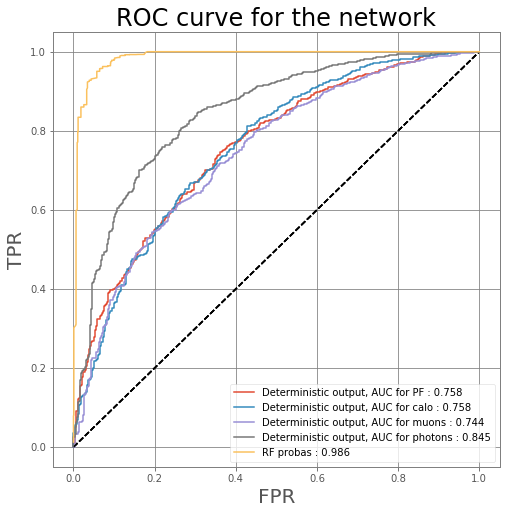

In [9]:
plt.figure(figsize=(8, 8))

for k in ch_probas_test:
    ch_proba = ch_probas_test[k]


    plt.plot([0, 1], [0, 1], '--', color='black')

    fpr, tpr, _ = roc_curve(y_test, ch_proba)
    auc_score = auc(fpr, tpr, reorder=True)
    plt.plot(fpr, tpr, label='Deterministic output, AUC for %s : %.3lf' % (k, auc_score))
    print ('AUC for %s : %.3lf' % (k, auc_score))


fpr, tpr, _ = roc_curve(y_test, rf_test, sample_weight=weights[indx_test])
auc_score = auc(fpr, tpr, reorder=True)
plt.plot(fpr, tpr, label='RF probas : %.3lf' % auc_score)


plt.legend(loc='lower right')
plt.title('ROC curve for the network', fontsize=24)
plt.xlabel('FPR', fontsize=20)
plt.ylabel('TPR', fontsize=20)
plt.show()

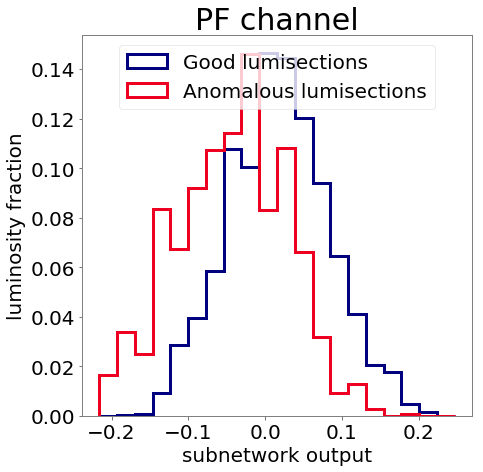

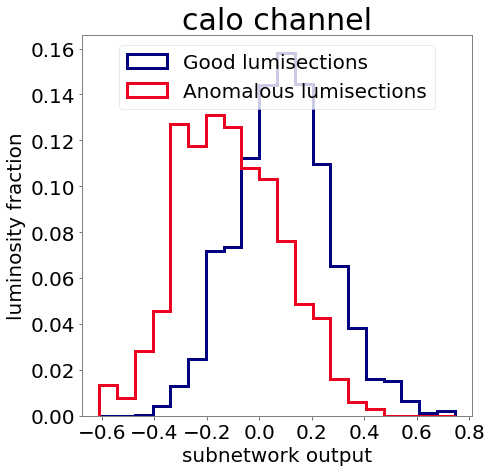

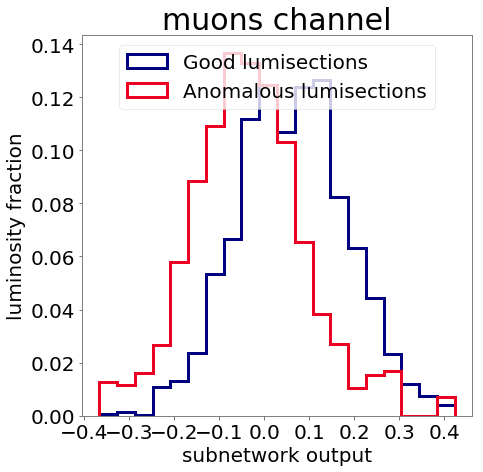

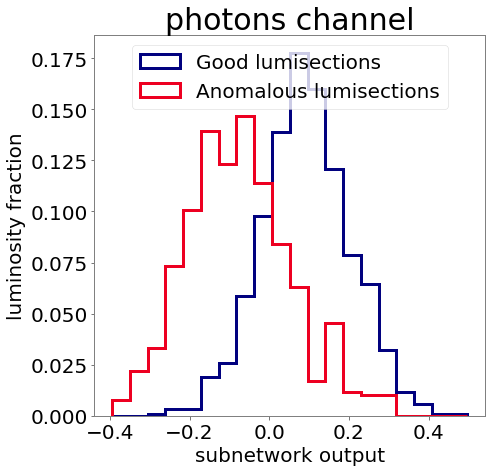

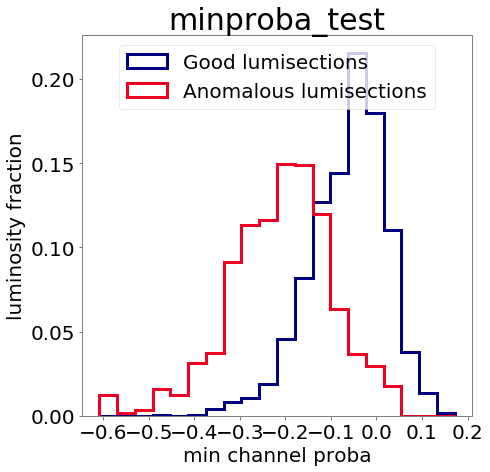

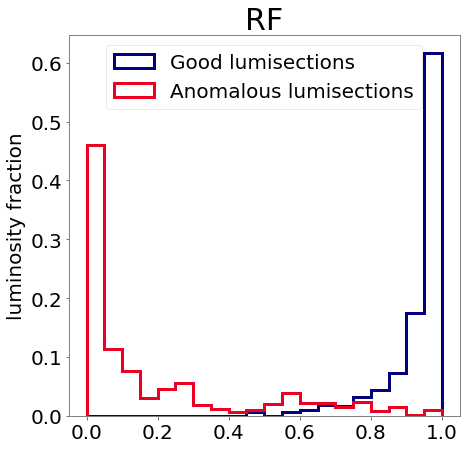

In [10]:
for k in ch_probas_test:
    proba = ch_probas_test[k]
    colors = ['#ed0021ff','#01017f']
    plt.figure(figsize=(7, 7))
    plt.hist([
            proba[labels[indx_test] == 0.0],
            proba[labels[indx_test] == 1.0]
    ],bins=20, weights=[
        weights[indx_test][labels[indx_test] == 0.0] / np.sum(weights[indx_test][labels[indx_test] == 0.0]),
        weights[indx_test][labels[indx_test] == 1.0] / np.sum(weights[indx_test][labels[indx_test] == 1.0])
    ], histtype='step', label=['Anomalous lumisections', 'Good lumisections'], lw=3,
         alpha=1, fill= False, color=colors)
    plt.legend(loc='upper center', fontsize=20)
    plt.title('%s channel' % k, fontsize=30, color = 'black' )
    plt.ylabel('luminosity fraction', fontsize=20, color = 'black')
    plt.xlabel(r'subnetwork output', fontsize=20, color = 'black')
    plt.xticks(fontsize=20, color = 'black')
    plt.yticks(fontsize=20, color = 'black')
    plt.grid(False)
    plt.axis('on')
    plt.show()
    
proba = ch_probas_test.min(axis=1)
plt.figure(figsize=(7, 7))
plt.hist([
        proba[labels[indx_test] == 0.0],
        proba[labels[indx_test] == 1.0]
],bins=20, weights=[
    weights[indx_test][labels[indx_test] == 0.0] / np.sum(weights[indx_test][labels[indx_test] == 0.0]),
    weights[indx_test][labels[indx_test] == 1.0] / np.sum(weights[indx_test][labels[indx_test] == 1.0])
], histtype='step', label=['Anomalous lumisections', 'Good lumisections'], lw=3,
     alpha=1, fill= False, color=colors)
plt.legend(loc='upper center', fontsize=20)
plt.title('minproba_test' , fontsize=30, color = 'black' )
plt.ylabel('luminosity fraction', fontsize=20, color = 'black')
plt.xlabel(r'min channel proba', fontsize=20, color = 'black')
plt.xticks(fontsize=20, color = 'black')
plt.yticks(fontsize=20, color = 'black')
plt.grid(False)
plt.axis('on')
plt.show()


proba = rf_test
plt.figure(figsize=(7, 7))
plt.hist([
        proba[labels[indx_test] == 0.0],
        proba[labels[indx_test] == 1.0]
],bins=20, weights=[
    weights[indx_test][labels[indx_test] == 0.0] / np.sum(weights[indx_test][labels[indx_test] == 0.0]),
    weights[indx_test][labels[indx_test] == 1.0] / np.sum(weights[indx_test][labels[indx_test] == 1.0])
], histtype='step', label=['Anomalous lumisections', 'Good lumisections'], lw=3,
     alpha=1, fill= False, color=colors)
plt.legend(loc='upper center', fontsize=20)
plt.title('RF' , fontsize=30, color = 'black' )
plt.ylabel('luminosity fraction', fontsize=20, color = 'black')
#plt.xlabel(r'min subnetwork output', fontsize=20, color = 'black')
plt.xticks(fontsize=20, color = 'black')
plt.yticks(fontsize=20, color = 'black')
plt.grid(False)
plt.axis('on')
plt.show()

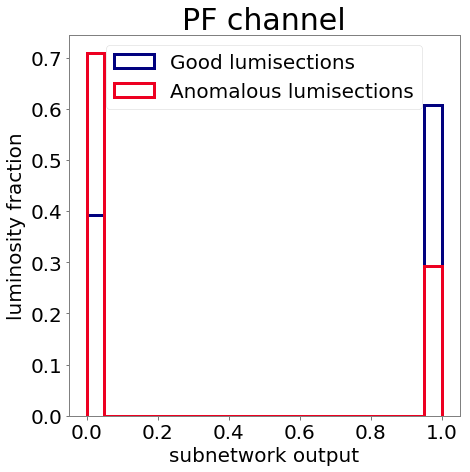

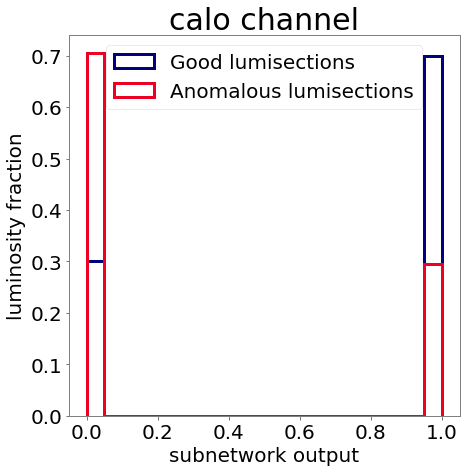

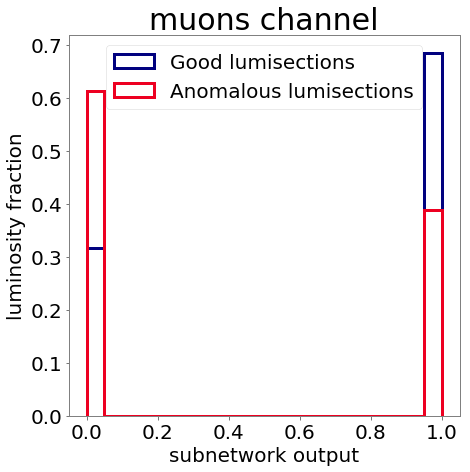

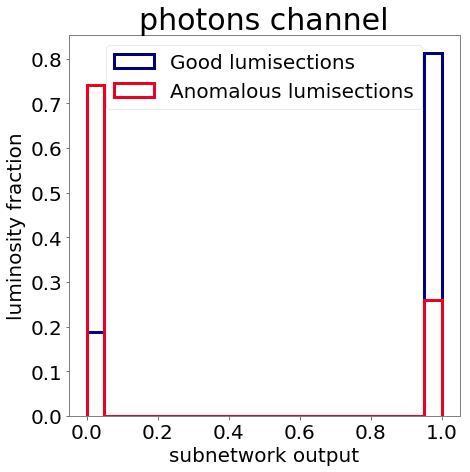

In [11]:
for k in ch_probas_test:
    proba = ch_probas_test[k]
    proba = np.where(proba<0, 0, 1)
    colors = ['#ed0021ff','#01017f']
    plt.figure(figsize=(7, 7))
    plt.hist([
            proba[labels[indx_test] == 0.0],
            proba[labels[indx_test] == 1.0]
    ],bins=20, weights=[
        weights[indx_test][labels[indx_test] == 0.0] / np.sum(weights[indx_test][labels[indx_test] == 0.0]),
        weights[indx_test][labels[indx_test] == 1.0] / np.sum(weights[indx_test][labels[indx_test] == 1.0])
    ], histtype='step', label=['Anomalous lumisections', 'Good lumisections'], lw=3,
         alpha=1, fill= False, color=colors)
    plt.legend(loc='upper center', fontsize=20)
    plt.title('%s channel' % k, fontsize=30, color = 'black' )
    plt.ylabel('luminosity fraction', fontsize=20, color = 'black')
    plt.xlabel(r'subnetwork output', fontsize=20, color = 'black')
    plt.xticks(fontsize=20, color = 'black')
    plt.yticks(fontsize=20, color = 'black')
    plt.grid(False)
    plt.axis('on')
    plt.show()

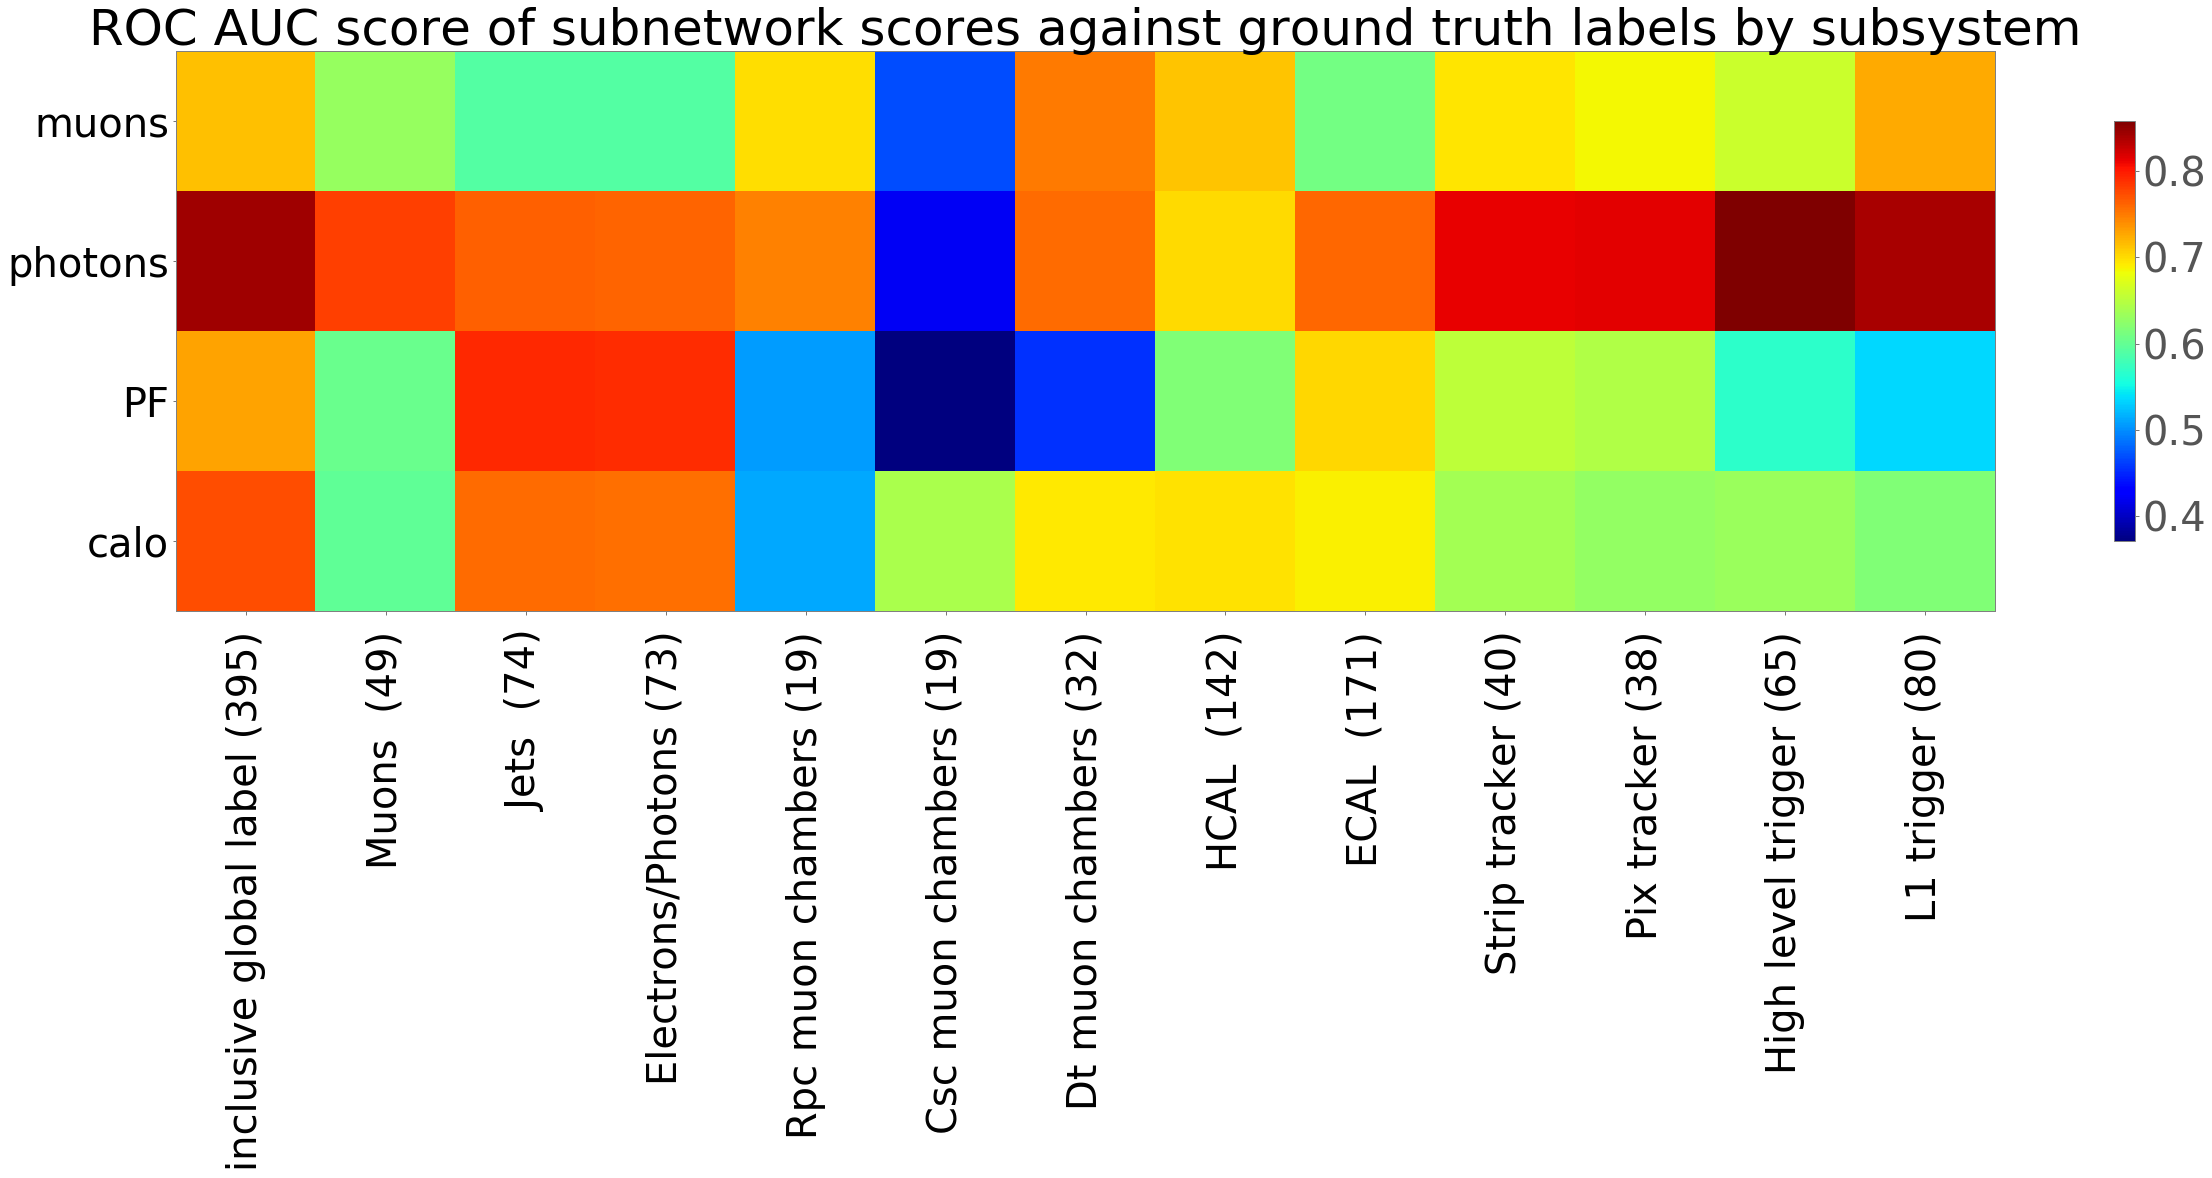

In [12]:
metric = roc_auc_score
met_name = 'roc_auc_score'



channels = ['muons', 'photons', 'PF', 'calo']
sub_systems = sorted(sub_labels.keys())

aucs = np.ones(shape=(len(channels), len(sub_systems_short))) / 2.0

for i, channel in enumerate(channels):
    for j, sub_system in enumerate(sub_systems_short):
        aucs[i, j] = metric(sub_labels[sub_system][indx_test], ch_probas_test[channel], sample_weight=weights[indx_test])

            
            
fig = plt.figure(figsize=(36, 14))

im = plt.imshow(aucs, interpolation='None', aspect=1, cmap = 'jet')
plt.colorbar(im, shrink=0.75).ax.tick_params(labelsize=40) 


plt.xticks(np.arange(len(sub_systems_short)), [subsytem_descriptions_short[k]+" ("+str(len(np.where(sub_labels[k][indx_test]==0)[0]))+") " for k in sub_systems_short], rotation=90, fontsize=40, color = 'black')
plt.yticks(np.arange(4), [ "%s" % g for g in channels ], fontsize=40, color = 'black')
plt.title('ROC AUC score'+' of subnetwork scores against ground truth labels by subsystem', fontsize=50)
plt.grid(False)
plt.tight_layout()

plt.show()

## Ours

In [13]:
probas_test = np.load('//data/cms2010/probas_test_2010.npy').item()

Deterministic output, AUC for muons : 0.902
Deterministic output, AUC for photons : 0.944
Deterministic output, AUC for PF : 0.906
Deterministic output, AUC for calo : 0.962


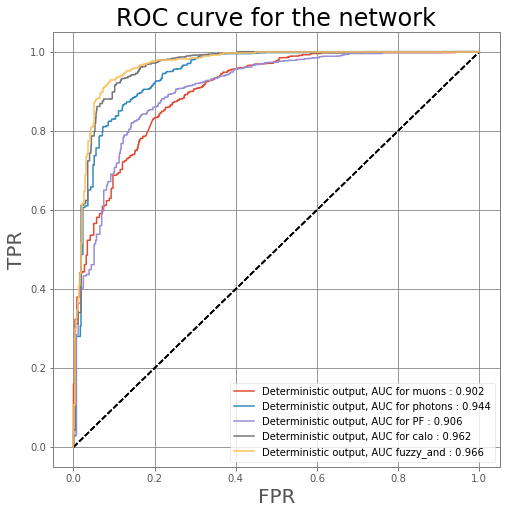

In [14]:
plt.figure(figsize=(8, 8))

sum_pred = np.zeros((len(indx_test)))
log_and = np.ones((len(indx_test)))
for k in channels_features:
    common_proba = probas_test[k]#(indx_test)
    sum_pred += common_proba
    log_and*= common_proba


    plt.plot([0, 1], [0, 1], '--', color='black')

    fpr, tpr, _ = roc_curve(labels[indx_test], common_proba, sample_weight=weights[indx_test])
    auc_score = auc(fpr, tpr, reorder=True)
    plt.plot(fpr, tpr, label='Deterministic output, AUC for %s : %.3lf' % (k, auc_score))
    print ('Deterministic output, AUC for %s : %.3lf' % (k, auc_score))
f_and = np.exp(sum_pred - 4.)

fpr, tpr, _ = roc_curve(labels[indx_test], f_and)
auc_score = auc(fpr, tpr, reorder=True)
plt.plot(fpr, tpr, label='Deterministic output, AUC fuzzy_and : %.3lf' % auc_score)


plt.legend(loc='lower right')
plt.title('ROC curve for the network', fontsize=24)
plt.xlabel('FPR', fontsize=20)
plt.ylabel('TPR', fontsize=20)
plt.show()

In [15]:
minproba_test = np.min(np.vstack((probas_test['PF'], probas_test['calo'],
                                 probas_test['muons'], probas_test["photons"])), axis=0)

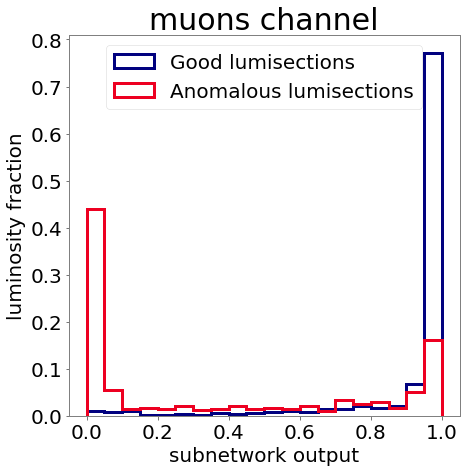

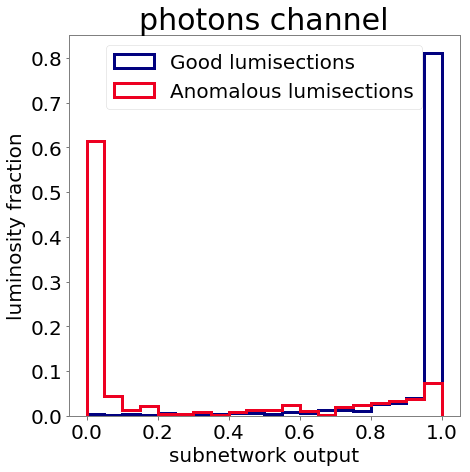

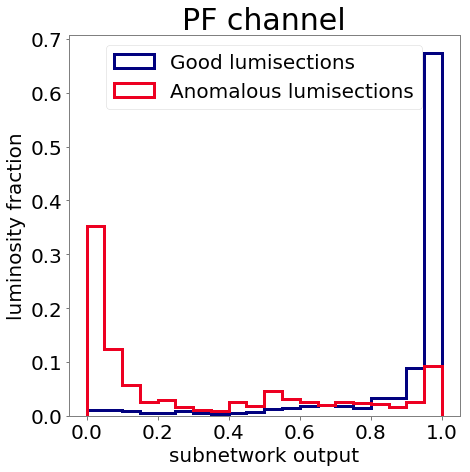

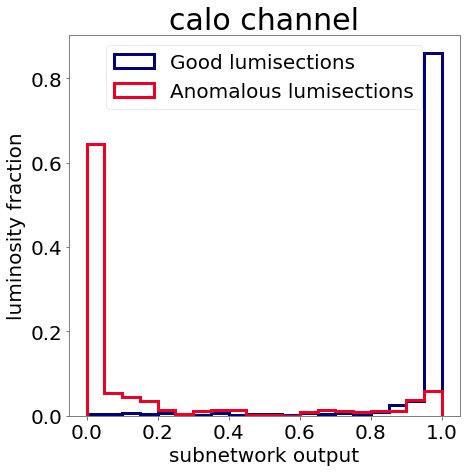

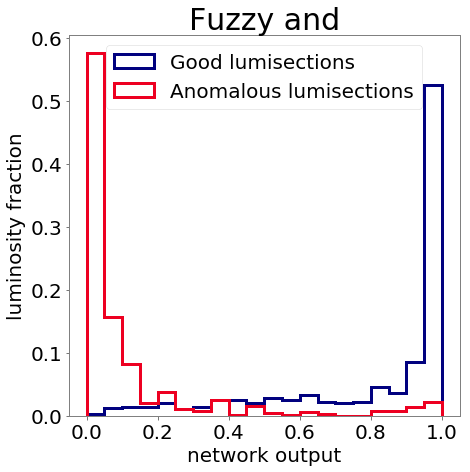

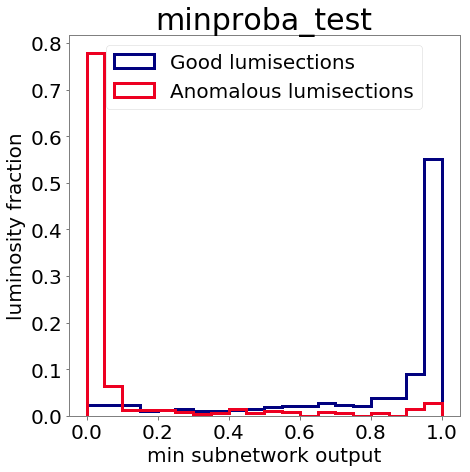

In [16]:
indx = indx_test
probas = probas_test
minproba = minproba_test

sum_pred = np.zeros((len(indx))) 
for k in probas_test:
    proba = probas[k]
    sum_pred += proba
    colors = ['#ed0021ff','#01017f']
    plt.figure(figsize=(7, 7))
    plt.hist([
            proba[labels[indx] == 0.0],
            proba[labels[indx] == 1.0]
    ],bins=20, range=(0, 1), weights=[
        weights[indx][labels[indx] == 0.0] / np.sum(weights[indx][labels[indx] == 0.0]),
        weights[indx][labels[indx] == 1.0] / np.sum(weights[indx][labels[indx] == 1.0])
    ], histtype='step', label=['Anomalous lumisections', 'Good lumisections'], lw=3,
         alpha=1, fill= False, color=colors)
    plt.legend(loc='upper center', fontsize=20)
    plt.title('%s channel' % k, fontsize=30, color = 'black' )
    plt.ylabel('luminosity fraction', fontsize=20, color = 'black')
    plt.xlabel(r'subnetwork output', fontsize=20, color = 'black')
    plt.xticks(fontsize=20, color = 'black')
    plt.yticks(fontsize=20, color = 'black')
    plt.grid(False)
    plt.axis('on')
    
plt.figure(figsize=(7, 7))   
f_and = np.exp(sum_pred - 4.)
plt.hist([
        f_and[labels[indx] == 0.0],
        f_and[labels[indx] == 1.0]
],bins=20, range=(0, 1), weights=[
    weights[indx][labels[indx] == 0.0] / np.sum(weights[indx][labels[indx] == 0.0]),
    weights[indx][labels[indx] == 1.0] / np.sum(weights[indx][labels[indx] == 1.0])
], histtype='step', label=['Anomalous lumisections', 'Good lumisections'], lw=3,
     alpha=1, fill= False, color=colors)
plt.legend(loc='upper center', fontsize=20)
plt.title("Fuzzy and", fontsize=30, color = 'black' )
plt.ylabel('luminosity fraction', fontsize=20, color = 'black')
plt.xlabel(r'network output', fontsize=20, color = 'black')
plt.xticks(fontsize=20, color = 'black')
plt.yticks(fontsize=20, color = 'black')
plt.grid(False)
plt.axis('on')
plt.show()




proba = minproba
plt.figure(figsize=(7, 7))
plt.hist([
        proba[labels[indx] == 0.0],
        proba[labels[indx] == 1.0]
],bins=20, range=(0, 1), weights=[
    weights[indx][labels[indx] == 0.0] / np.sum(weights[indx][labels[indx] == 0.0]),
    weights[indx][labels[indx] == 1.0] / np.sum(weights[indx][labels[indx] == 1.0])
], histtype='step', label=['Anomalous lumisections', 'Good lumisections'], lw=3,
     alpha=1, fill= False, color=colors)
plt.legend(loc='upper center', fontsize=20)
plt.title('minproba_test' , fontsize=30, color = 'black' )
plt.ylabel('luminosity fraction', fontsize=20, color = 'black')
plt.xlabel(r'min subnetwork output', fontsize=20, color = 'black')
plt.xticks(fontsize=20, color = 'black')
plt.yticks(fontsize=20, color = 'black')
plt.grid(False)
plt.axis('on')
plt.show()




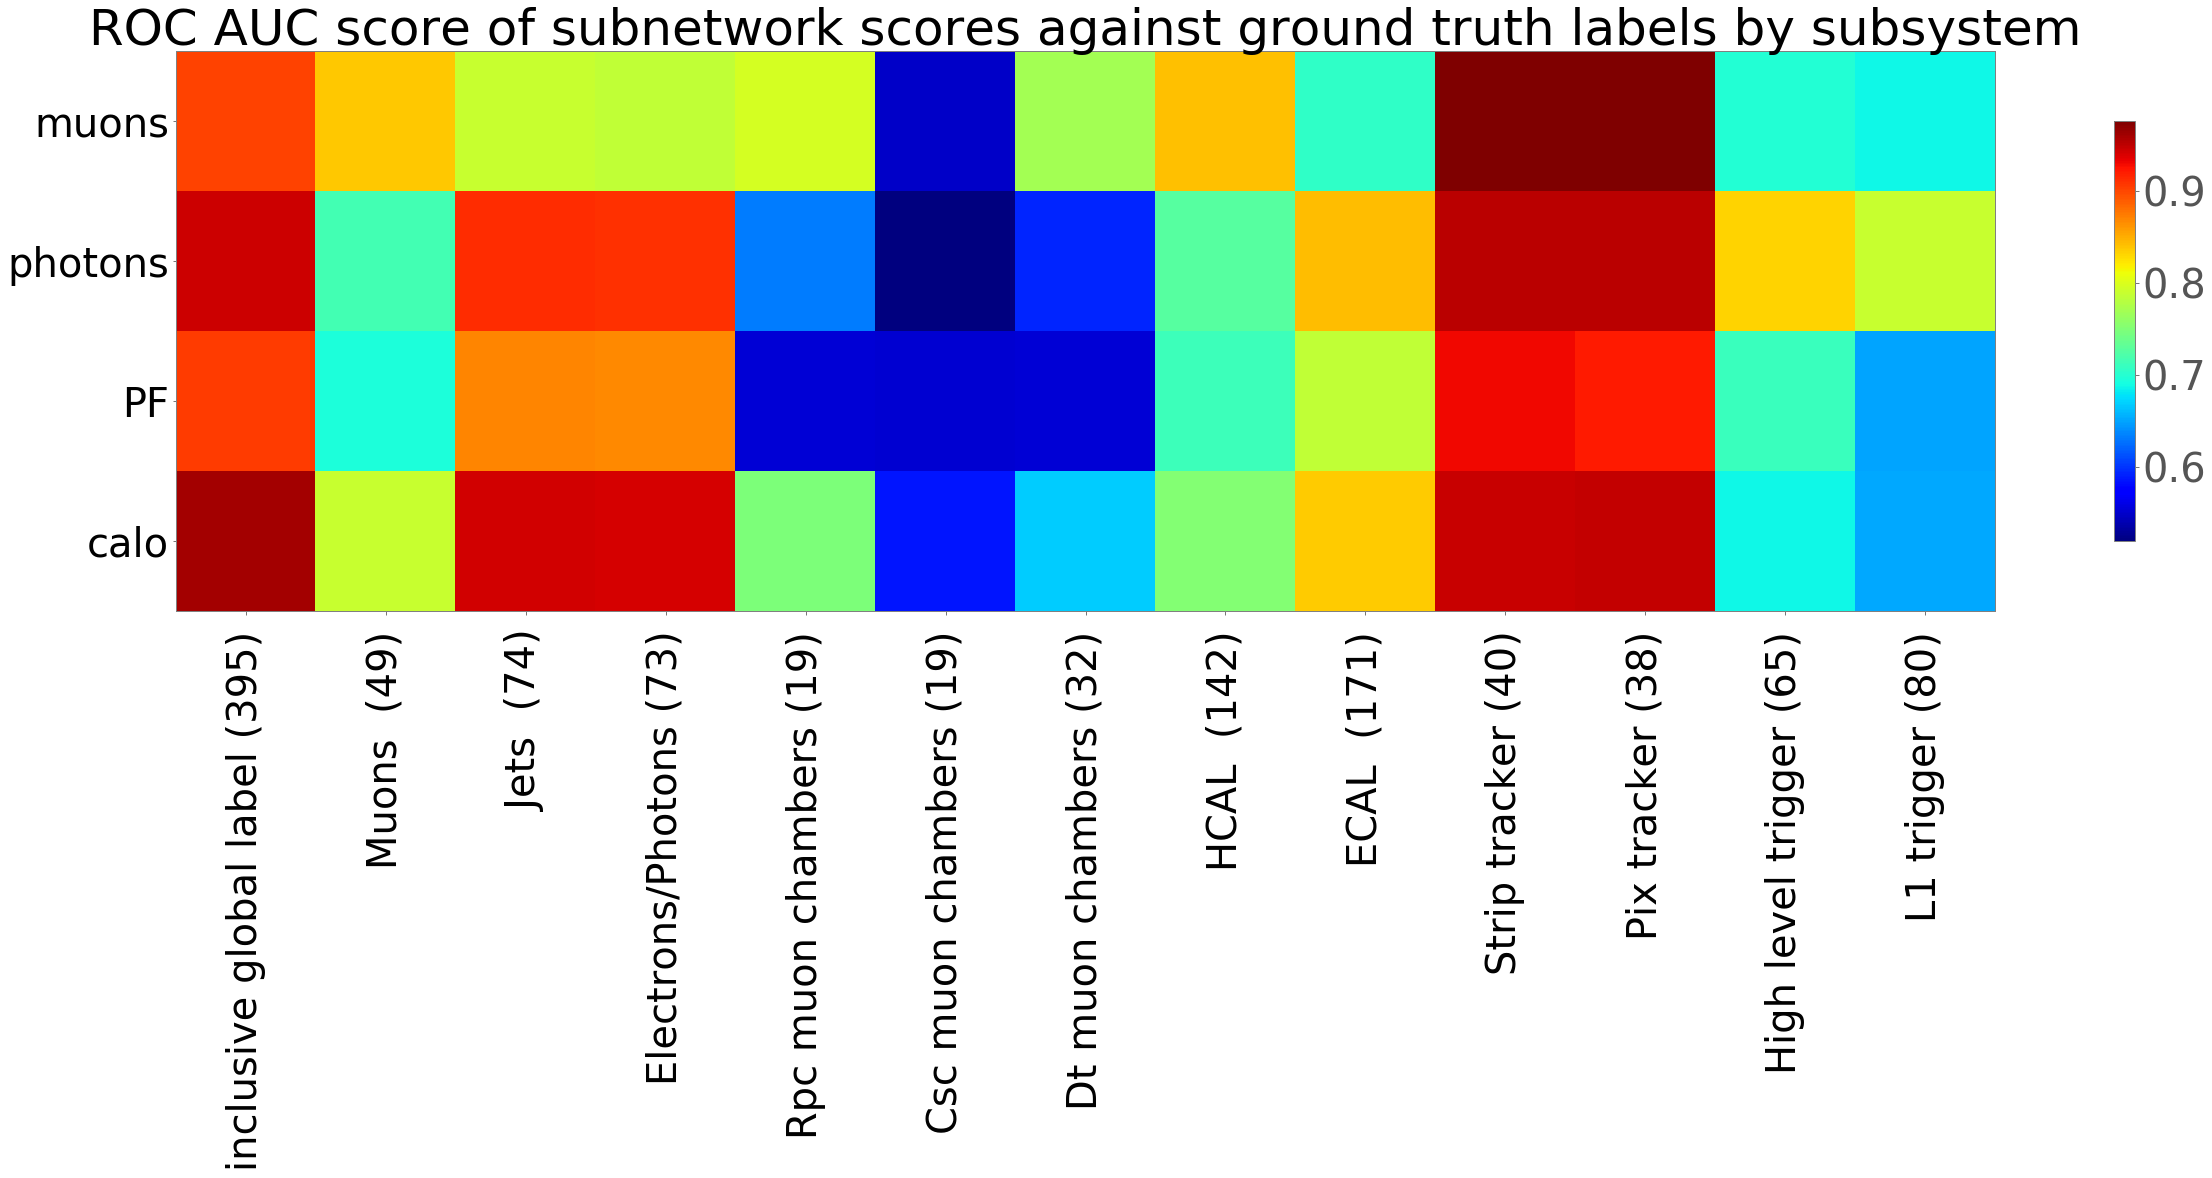

In [17]:
metric = roc_auc_score
met_name = 'roc_auc_score'
probas = probas_test
indx = indx_test


channels = ['muons', 'photons', 'PF', 'calo']
sub_systems = sorted(sub_labels.keys())

aucs = np.ones(shape=(len(channels), len(sub_systems_short))) / 2.0

for i, channel in enumerate(channels):
    for j, sub_system in enumerate(sub_systems_short):
        try:
            aucs[i, j] = metric(sub_labels[sub_system][indx_test], probas[channel], sample_weight=weights[indx_test])
            
        except Exception as e:
            print (e)
            
            
fig = plt.figure(figsize=(36, 14))

im = plt.imshow(aucs, interpolation='None', aspect=1, cmap = 'jet')
plt.colorbar(im, shrink=0.75).ax.tick_params(labelsize=40) 


plt.xticks(np.arange(len(sub_systems_short)), [subsytem_descriptions_short[k]+" ("+str(len(np.where(sub_labels[k][indx_test]==0)[0]))+") " for k in sub_systems_short], rotation=90, fontsize=40, color = 'black')
plt.yticks(np.arange(4), [ "%s" % g for g in channels ], fontsize=40, color = 'black')
plt.yticks(np.arange(4), [ "%s" % g for g in channels ], fontsize=40, color = 'black')
plt.title('ROC AUC score'+' of subnetwork scores against ground truth labels by subsystem', fontsize=50)
plt.grid(False)
plt.tight_layout()

plt.show()

## Random

In [18]:
random_ch = np.load('//data/cms2010/random_ch.npy')

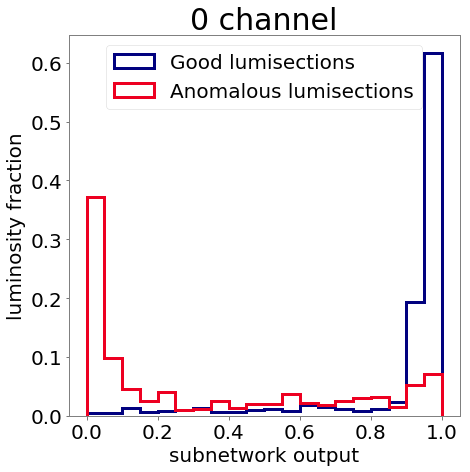

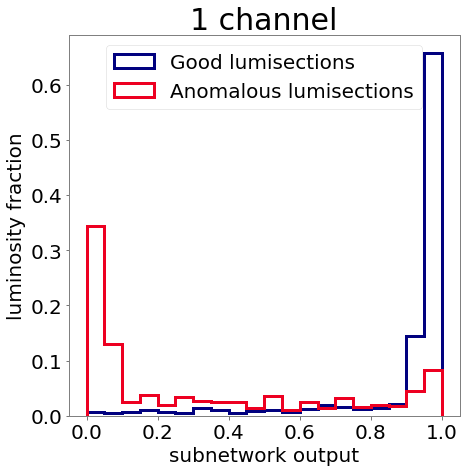

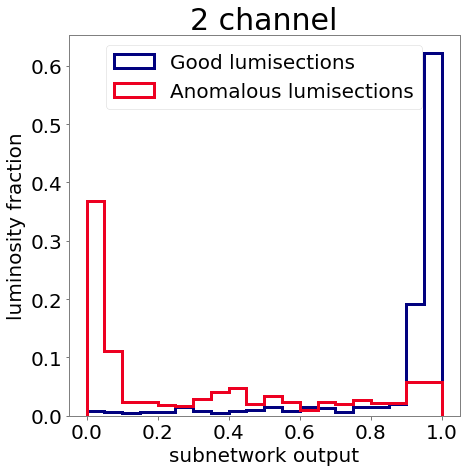

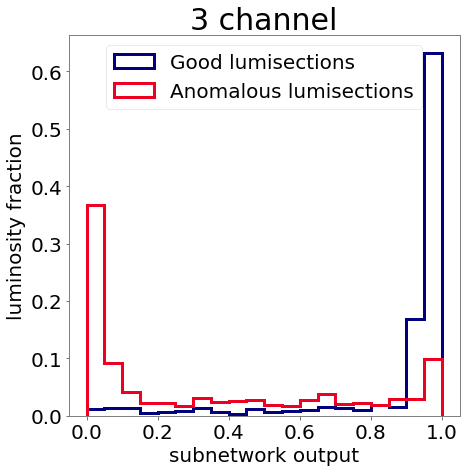

In [19]:

for k in range(4):
    proba = random_ch[:,k]

    colors = ['#ed0021ff','#01017f']
    plt.figure(figsize=(7, 7))
    plt.hist([
            proba[labels[indx] == 0.0],
            proba[labels[indx] == 1.0]
    ],bins=20, range=(0, 1), weights=[
        weights[indx][labels[indx] == 0.0] / np.sum(weights[indx][labels[indx] == 0.0]),
        weights[indx][labels[indx] == 1.0] / np.sum(weights[indx][labels[indx] == 1.0])
    ], histtype='step', label=['Anomalous lumisections', 'Good lumisections'], lw=3,
         alpha=1, fill= False, color=colors)
    plt.legend(loc='upper center', fontsize=20)
    plt.title('%s channel' % k, fontsize=30, color = 'black' )
    plt.ylabel('luminosity fraction', fontsize=20, color = 'black')
    plt.xlabel(r'subnetwork output', fontsize=20, color = 'black')
    plt.xticks(fontsize=20, color = 'black')
    plt.yticks(fontsize=20, color = 'black')
    plt.grid(False)
    plt.axis('on')

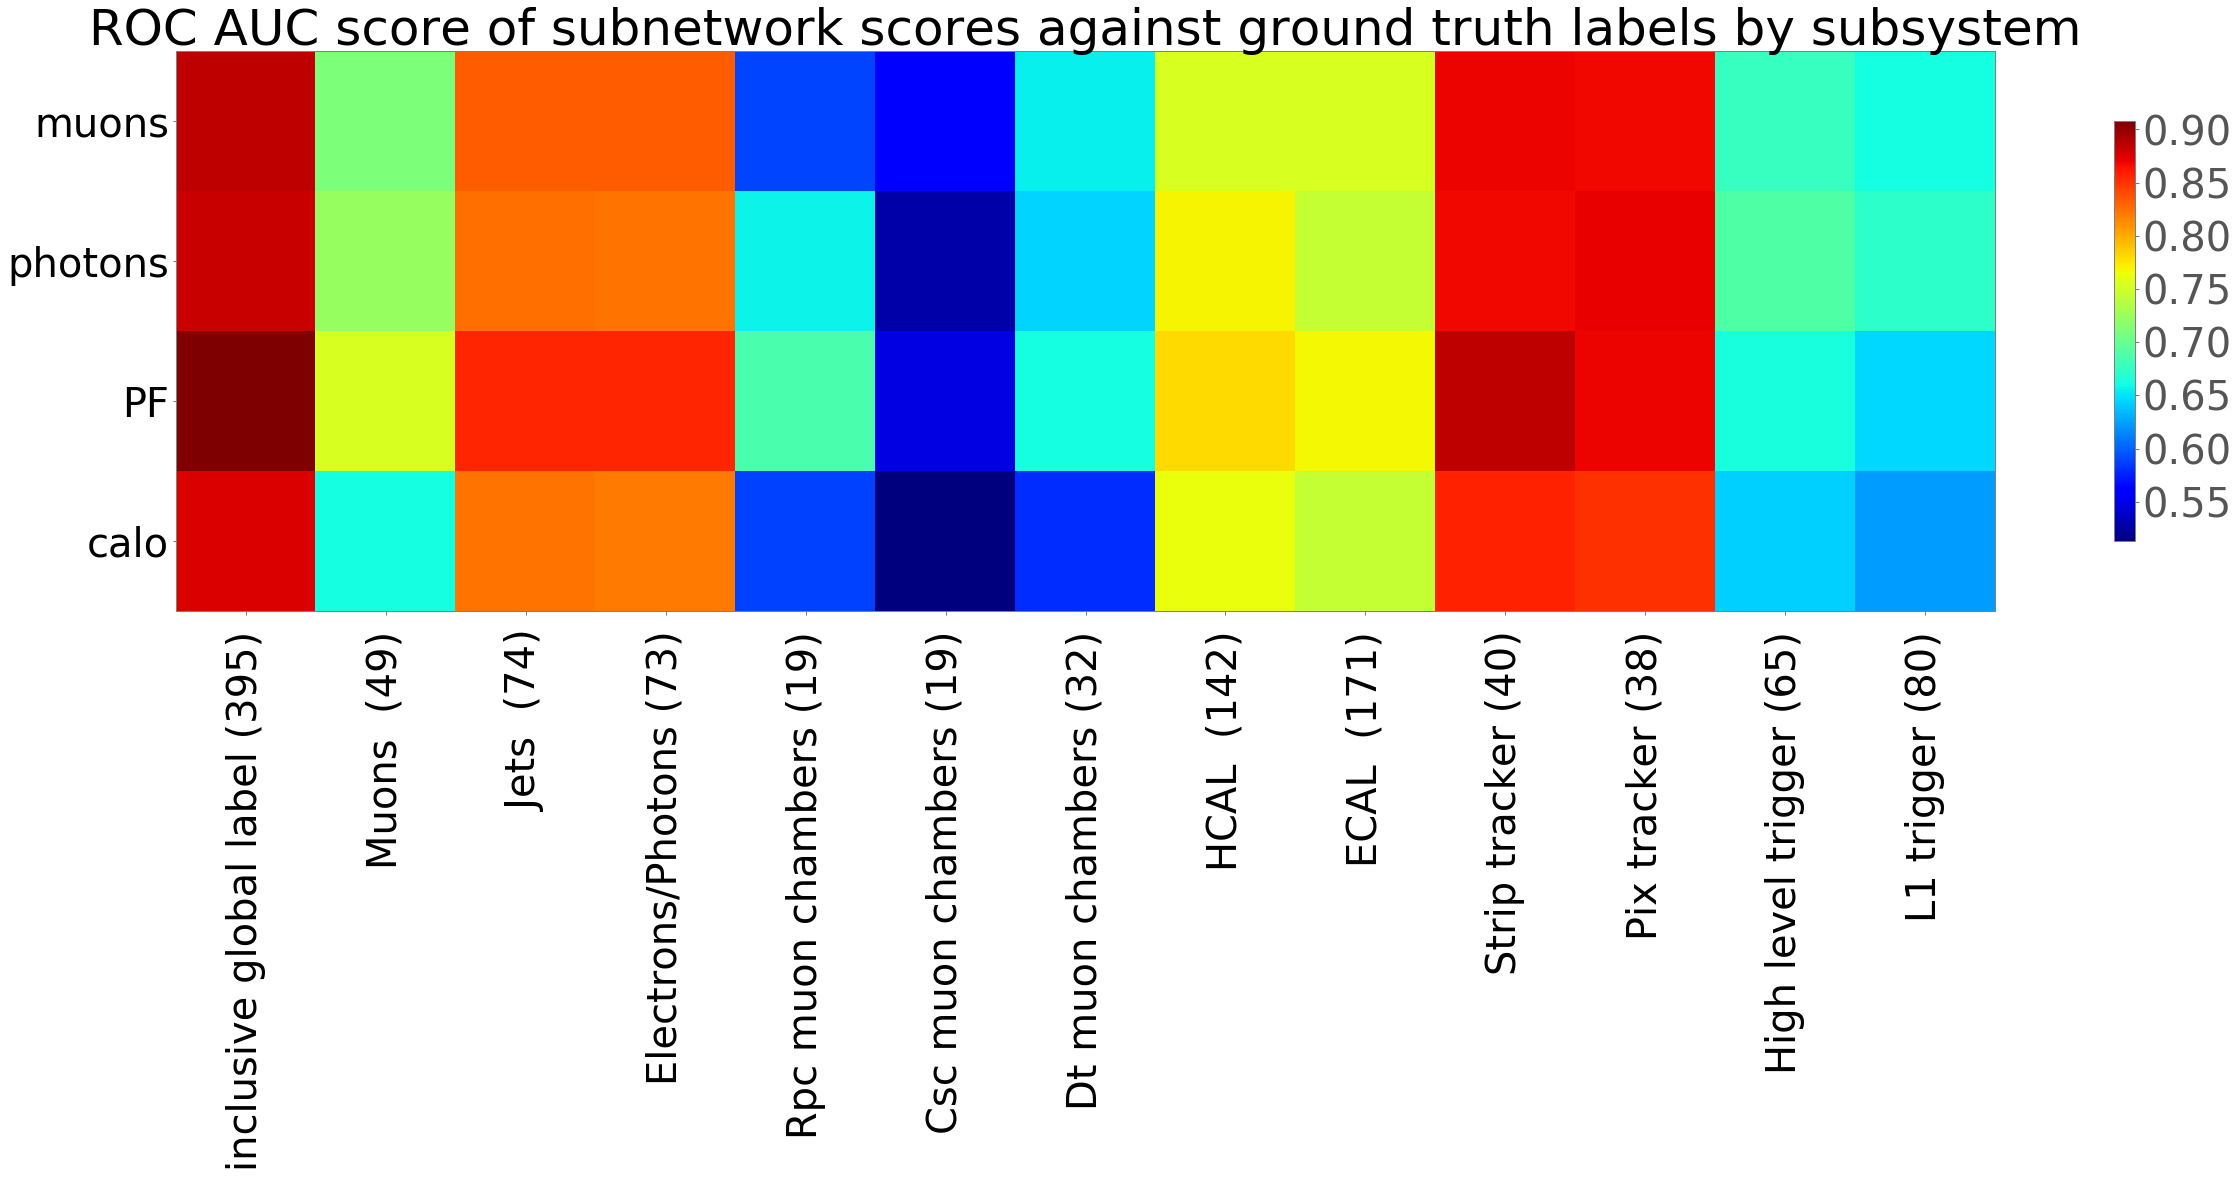

In [20]:
metric = roc_auc_score
met_name = 'roc_auc_score'
probas = probas_test
indx = indx_test



channels = ['muons', 'photons', 'PF', 'calo']
sub_systems = sorted(sub_labels.keys())

aucs = np.ones(shape=(len(channels), len(sub_systems_short))) / 2.0

for i, channel in enumerate(channels):
    for j, sub_system in enumerate(sub_systems_short):
        try:
            aucs[i, j] = metric(sub_labels[sub_system][indx_test], random_ch[:,i], sample_weight=weights[indx_test])
            
        except Exception as e:
            print (e)
            
            
fig = plt.figure(figsize=(36, 14))

im = plt.imshow(aucs, interpolation='None', aspect=1, cmap = 'jet')
plt.colorbar(im, shrink=0.75).ax.tick_params(labelsize=40) 


plt.xticks(np.arange(len(sub_systems_short)), [subsytem_descriptions_short[k]+" ("+str(len(np.where(sub_labels[k][indx_test]==0)[0]))+") " for k in sub_systems_short], rotation=90, fontsize=40, color = 'black')
plt.yticks(np.arange(4), [ "%s" % g for g in channels ], fontsize=40, color = 'black')
plt.yticks(np.arange(4), [ "%s" % g for g in channels ], fontsize=40, color = 'black')
plt.title('ROC AUC score'+' of subnetwork scores against ground truth labels by subsystem', fontsize=50)
plt.grid(False)
plt.tight_layout()

plt.show()